### Cell 1: Imports

In [1]:
import pandas as pd
import gzip
from io import StringIO
import matplotlib.pyplot as plt
from kneed import KneeLocator

### Cell 2: Load expression matrix

In [2]:
# Load the expression matrix and skip metadata rows at the top
with gzip.open('../data/GSE2034_series_matrix.txt.gz', 'rt') as f:
    raw_lines = f.readlines()
    
# Find the header line
start_idx = next(i for i, line in enumerate(raw_lines) if line.startswith("!series_matrix_table_begin"))
end_idx = next(i for i, line in enumerate(raw_lines) if line.startswith("!series_matrix_table_end"))

# Read the expression matrix section
expr_data = pd.read_csv(
    StringIO("".join(raw_lines[start_idx+1:end_idx])),
    sep="\\t", index_col=0
)

# Remove quotes from sample IDs
expr_data.columns = expr_data.columns.str.replace('"', '').str.replace('GSM', '')
expr_data = expr_data.T
expr_data.index.name = 'Sample'

print("Expression data shape:", expr_data.shape)
expr_data.head()

C:\Users\chhua\AppData\Local\Temp\ipykernel_25640\2180476185.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  expr_data = pd.read_csv(


Expression data shape: (286, 22283)


"""ID_REF""","""1007_s_at""","""1053_at""","""117_at""","""121_at""","""1255_g_at""","""1294_at""","""1316_at""","""1320_at""","""1405_i_at""","""1431_at""",...,"""AFFX-r2-Hs28SrRNA-5_at""","""AFFX-r2-Hs28SrRNA-M_at""","""AFFX-r2-P1-cre-3_at""","""AFFX-r2-P1-cre-5_at""","""AFFX-ThrX-3_at""","""AFFX-ThrX-5_at""","""AFFX-ThrX-M_at""","""AFFX-TrpnX-3_at""","""AFFX-TrpnX-5_at""","""AFFX-TrpnX-M_at"""
Sample,,,,,,,,,,,,,,,,,,,,,
36777,3848.1,228.9,213.1,1009.4,31.8,551.5,176.7,11.9,309.3,49.9,...,619.9,661.5,33168.9,25644.4,11.1,9.2,25.0,4.2,7.0,10.0
36778,6520.9,112.5,189.8,2083.3,145.8,802.8,278.4,28.3,449.0,122.9,...,511.3,716.1,54401.4,40720.0,17.1,62.0,21.4,9.3,11.2,15.7
36779,5285.7,178.4,269.7,1203.4,42.5,557.5,183.3,56.4,101.9,85.9,...,1618.4,1189.3,61244.1,50878.7,6.4,8.4,7.4,7.1,64.0,4.1
36780,4043.7,398.7,312.4,1104.4,108.2,568.5,187.7,42.1,899.1,90.7,...,780.5,801.1,62292.1,46870.8,13.5,10.8,16.0,4.6,12.2,7.3
36781,4263.6,417.7,327.1,1043.3,69.2,653.2,185.8,21.8,3629.3,96.0,...,276.0,191.1,57295.1,40847.1,19.8,30.5,22.1,7.3,5.5,11.6


### Cell 3: Parse relapse labels from .soft file

In [3]:
# Extract relapse labels from the .soft file
sample_labels = {}
current_id = None

with gzip.open('../data/GSE2034_family.soft.gz', 'rt') as f:
    for line in f:
        if line.startswith("!Sample_geo_accession"):
            current_id = line.strip().split()[-1].replace("GSM", "")
        if line.startswith("!Sample_characteristics_ch1") and current_id:
            if "bone relapses" in line.lower():
                value = line.strip().split(":")[-1].strip()
                if value in ["0", "1"]:
                    sample_labels[current_id] = int(value)

# Create label DataFrame
label_df = pd.DataFrame.from_dict(sample_labels, orient='index', columns=['label'])
label_df.index.name = 'Sample'

# Check that it worked
print("Labels extracted:", label_df.shape)
display(label_df.head())


Labels extracted: (286, 1)


,label
Sample,
36777,0
36778,0
36779,0
36780,0
36781,0


### Cell 4: Merge and clean

In [4]:
# Align and merge data
common_samples = expr_data.index.intersection(label_df.index)
print(f"Common samples found: {len(common_samples)}")

expr_data = expr_data.loc[common_samples]
label_df = label_df.loc[common_samples]

data_merged = expr_data.merge(label_df, left_index=True, right_index=True)

print("Merged data shape:", data_merged.shape)
data_merged['label'].value_counts()
data_merged.head()

Common samples found: 286
Merged data shape: (286, 22284)


,"""1007_s_at""","""1053_at""","""117_at""","""121_at""","""1255_g_at""","""1294_at""","""1316_at""","""1320_at""","""1405_i_at""","""1431_at""",...,"""AFFX-r2-Hs28SrRNA-M_at""","""AFFX-r2-P1-cre-3_at""","""AFFX-r2-P1-cre-5_at""","""AFFX-ThrX-3_at""","""AFFX-ThrX-5_at""","""AFFX-ThrX-M_at""","""AFFX-TrpnX-3_at""","""AFFX-TrpnX-5_at""","""AFFX-TrpnX-M_at""",label
Sample,,,,,,,,,,,,,,,,,,,,,
36777,3848.1,228.9,213.1,1009.4,31.8,551.5,176.7,11.9,309.3,49.9,...,661.5,33168.9,25644.4,11.1,9.2,25.0,4.2,7.0,10.0,0
36778,6520.9,112.5,189.8,2083.3,145.8,802.8,278.4,28.3,449.0,122.9,...,716.1,54401.4,40720.0,17.1,62.0,21.4,9.3,11.2,15.7,0
36779,5285.7,178.4,269.7,1203.4,42.5,557.5,183.3,56.4,101.9,85.9,...,1189.3,61244.1,50878.7,6.4,8.4,7.4,7.1,64.0,4.1,0
36780,4043.7,398.7,312.4,1104.4,108.2,568.5,187.7,42.1,899.1,90.7,...,801.1,62292.1,46870.8,13.5,10.8,16.0,4.6,12.2,7.3,0
36781,4263.6,417.7,327.1,1043.3,69.2,653.2,185.8,21.8,3629.3,96.0,...,191.1,57295.1,40847.1,19.8,30.5,22.1,7.3,5.5,11.6,0


### Cell 5: Plot variance and find elbow

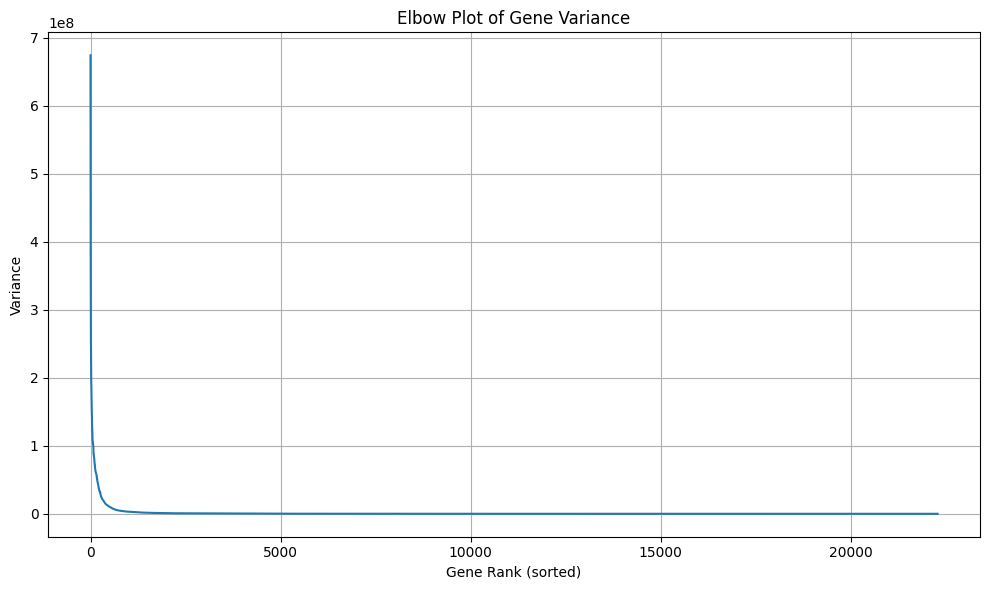

Elbow found at gene rank: 141


In [5]:
data_merged.columns = data_merged.columns.str.replace('"', '')
X = data_merged.drop(columns=["label"])
y = data_merged["label"]

# Compute variance and sort
variances = X.var(axis=0).sort_values(ascending=False)
sorted_var = variances.values

# Plot elbow
plt.figure(figsize=(10, 6))
plt.plot(sorted_var, label="Gene Variance")
plt.title("Elbow Plot of Gene Variance")
plt.xlabel("Gene Rank (sorted)")
plt.ylabel("Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Use KneeLocator to find elbow
knee = KneeLocator(range(len(sorted_var)), sorted_var, curve='convex', direction='decreasing')
elbow_index = knee.knee
print(f"Elbow found at gene rank: {elbow_index}")


### Cell 6: Select Top genes based on elbow and export output

In [6]:
# Select top genes using elbow index
top_genes = variances.head(elbow_index).index

X_filtered = X[top_genes].copy()
X_filtered["label"] = y

# Save the filtered data
X_filtered.to_csv('../data/filtered_expression_data.csv', index=False)
print(f"Filtered dataset saved with top {elbow_index} genes. Shape: {X_filtered.shape}")


Filtered dataset saved with top 141 genes. Shape: (286, 142)
